In [2]:
from os import path
import glob
import time

# Third-party
from astropy.table import Table, join
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from astroquery.gaia import Gaia
from pyia import GaiaData
Gaia.login(user='apricewh', password='7Gy2^otQNj6FKz6')

In [41]:
def reflex(c):
    c = coord.SkyCoord(c)
    # Correct for reflex motion
    v_sun = coord.Galactocentric.galcen_v_sun
    observed = c.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    return coord.Galactic(rep).transform_to(c.frame)

In [4]:
poly_q ='''SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1.5 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     {0.ra.degree}, {0.dec.degree}, 
                     {1.ra.degree}, {1.dec.degree}, 
                     {2.ra.degree}, {2.dec.degree}, 
                     {3.ra.degree}, {3.dec.degree})) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 
'''


gc_frame = coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc)

In [5]:
poly_c = gc.Pal5(phi1=[-15, -15, 15, 15] * u.deg,
                 phi2=[-5, 5, 5, -5] * u.deg)
poly_c = poly_c.transform_to(coord.ICRS)

(-25, 25)

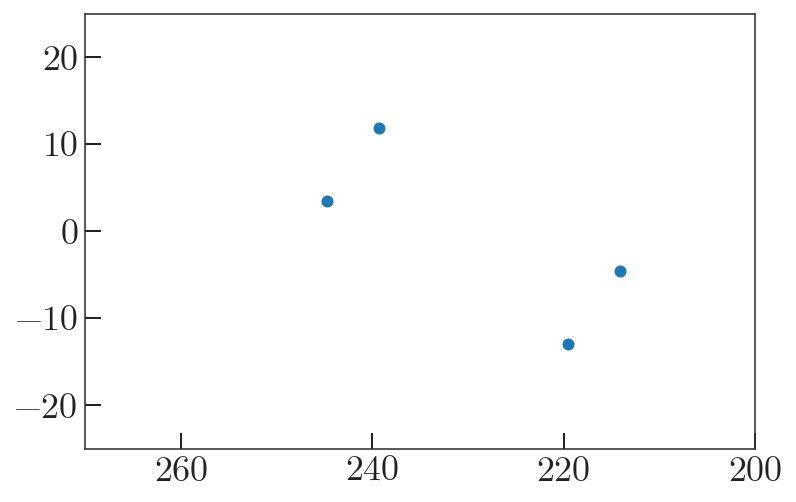

In [10]:
plt.scatter(poly_c.ra.degree, poly_c.dec.degree)

plt.xlim(270, 200)
plt.ylim(-25, 25)

In [11]:
q = poly_q.format(*poly_c)
print(q)

SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1.5 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     239.25650189398314, 11.826282700501773, 
                     244.72277212605562, 3.417864008497764, 
                     219.5808184507875, -13.0072727740957, 
                     214.13755542548802, -4.574039814429764)) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 



In [12]:
job = Gaia.launch_job_async(q)

Launched query: 'SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1.5 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     239.25650189398314, 11.826282700501773, 
                     244.72277212605562, 3.417864008497764, 
                     219.5808184507875, -13.0072727740957, 
                     214.13755542548802, -4.574039814429764)) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 
'

Query finished.


In [13]:
tbl = job.get_results()

In [14]:
g = GaiaData(tbl)

In [25]:
m5 = coord.SkyCoord.from_name('M5')
m5 = m5.transform_to(gc.Pal5)

In [42]:
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   distance=np.full(len(g), 22.)*u.kpc,
                   pm_ra_cosdec=g.pmra,
                   pm_dec=g.pmdec,
                   radial_velocity=np.zeros(len(g))*u.km/u.s)

ERROR! Session/line number was not unique in database. History logging moved to new session 6326


In [43]:
c_pal5 = reflex(c.transform_to(gc.Pal5))

In [64]:
prog_mask = ((np.abs(c_pal5.phi1.wrap_at(180*u.deg)) < 0.2*u.deg) & 
             (c_pal5.phi2 < -0.3*u.deg) & (c_pal5.phi2 > -1*u.deg))

ERROR! Session/line number was not unique in database. History logging moved to new session 6327


In [47]:
m5_mask = c_pal5.separation(m5) > 0.5*u.deg

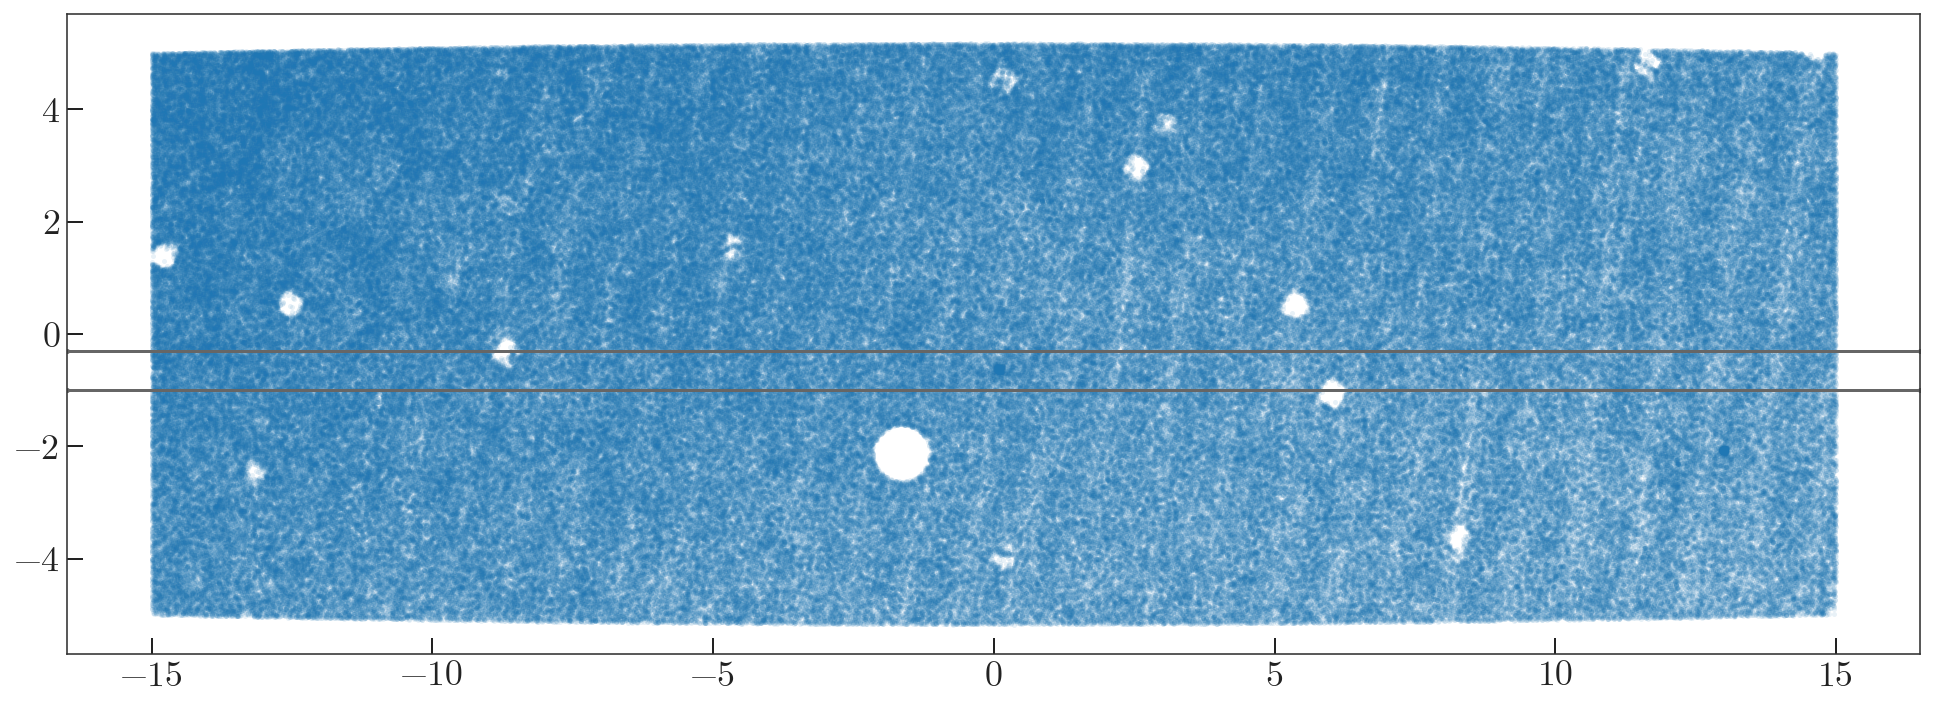

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(c_pal5.phi1.wrap_at(180*u.deg).degree[m5_mask],
        c_pal5.phi2.degree[m5_mask], 
        marker='.', linestyle='none', alpha=0.1)
ax.set_aspect('equal')
ax.axhline(-0.3)
ax.axhline(-1)
fig.tight_layout()

In [49]:
g_no_m5 = g[m5_mask]

In [50]:
no_m5_c = c_pal5[m5_mask]

In [74]:
pm1, pm2 = c_pal5.pm_phi1_cosphi2.to(u.mas/u.yr), c_pal5.pm_phi2.to(u.mas/u.yr)
pm_mask = ((pm1 < 3*u.mas/u.yr) & (pm1 > 0.5*u.mas/u.yr) &
           (pm2 < 1.3*u.mas/u.yr) & (pm2 > -1*u.mas/u.yr))

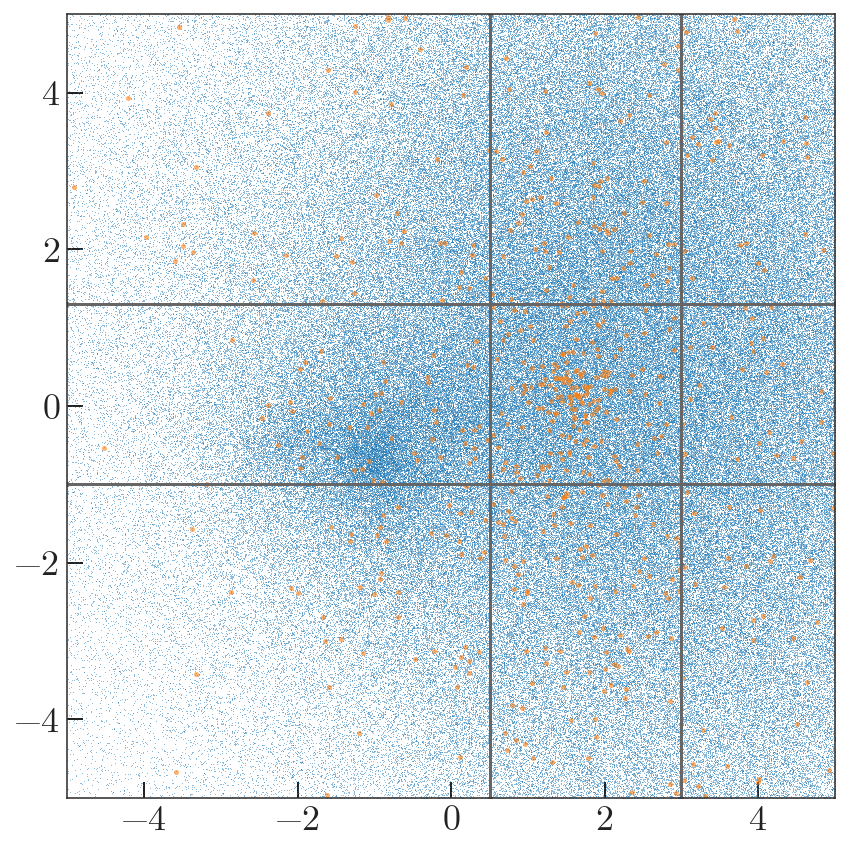

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pm1, pm2,
        marker=',', linestyle='none', alpha=0.5)

ax.plot(pm1[prog_mask], pm2[prog_mask],
        marker='.', linestyle='none', alpha=0.6)

ax.axvline(0.5)
ax.axvline(3)

ax.axhline(1.3)
ax.axhline(-1)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

fig.tight_layout()

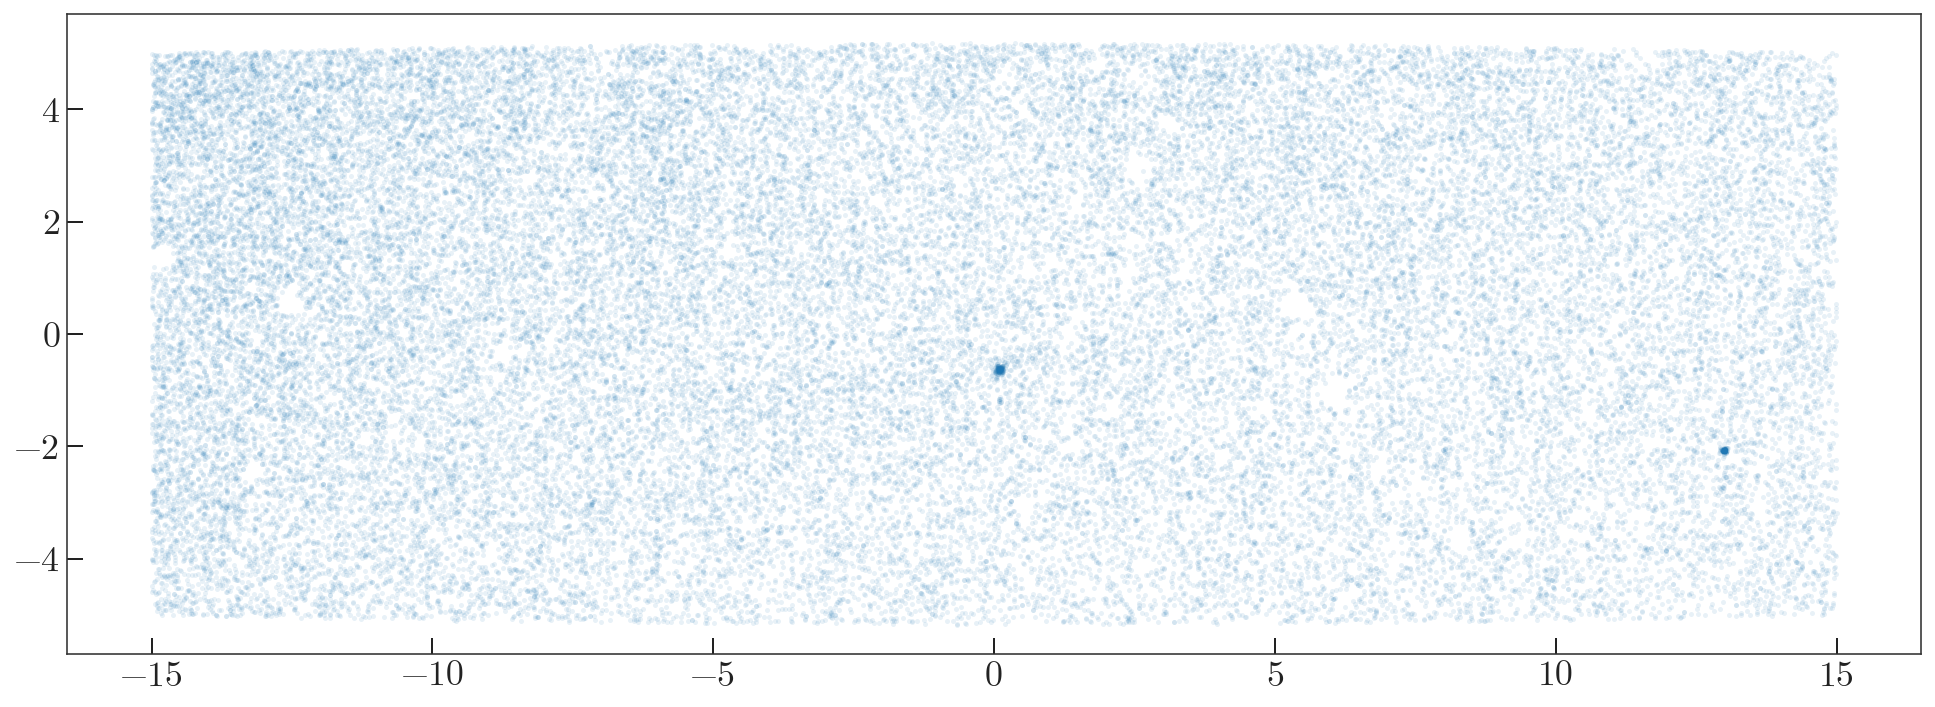

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(c_pal5.phi1.wrap_at(180*u.deg).degree[pm_mask],
        c_pal5.phi2.degree[pm_mask], 
        marker='.', linestyle='none', alpha=0.1)
ax.set_aspect('equal')
fig.tight_layout()

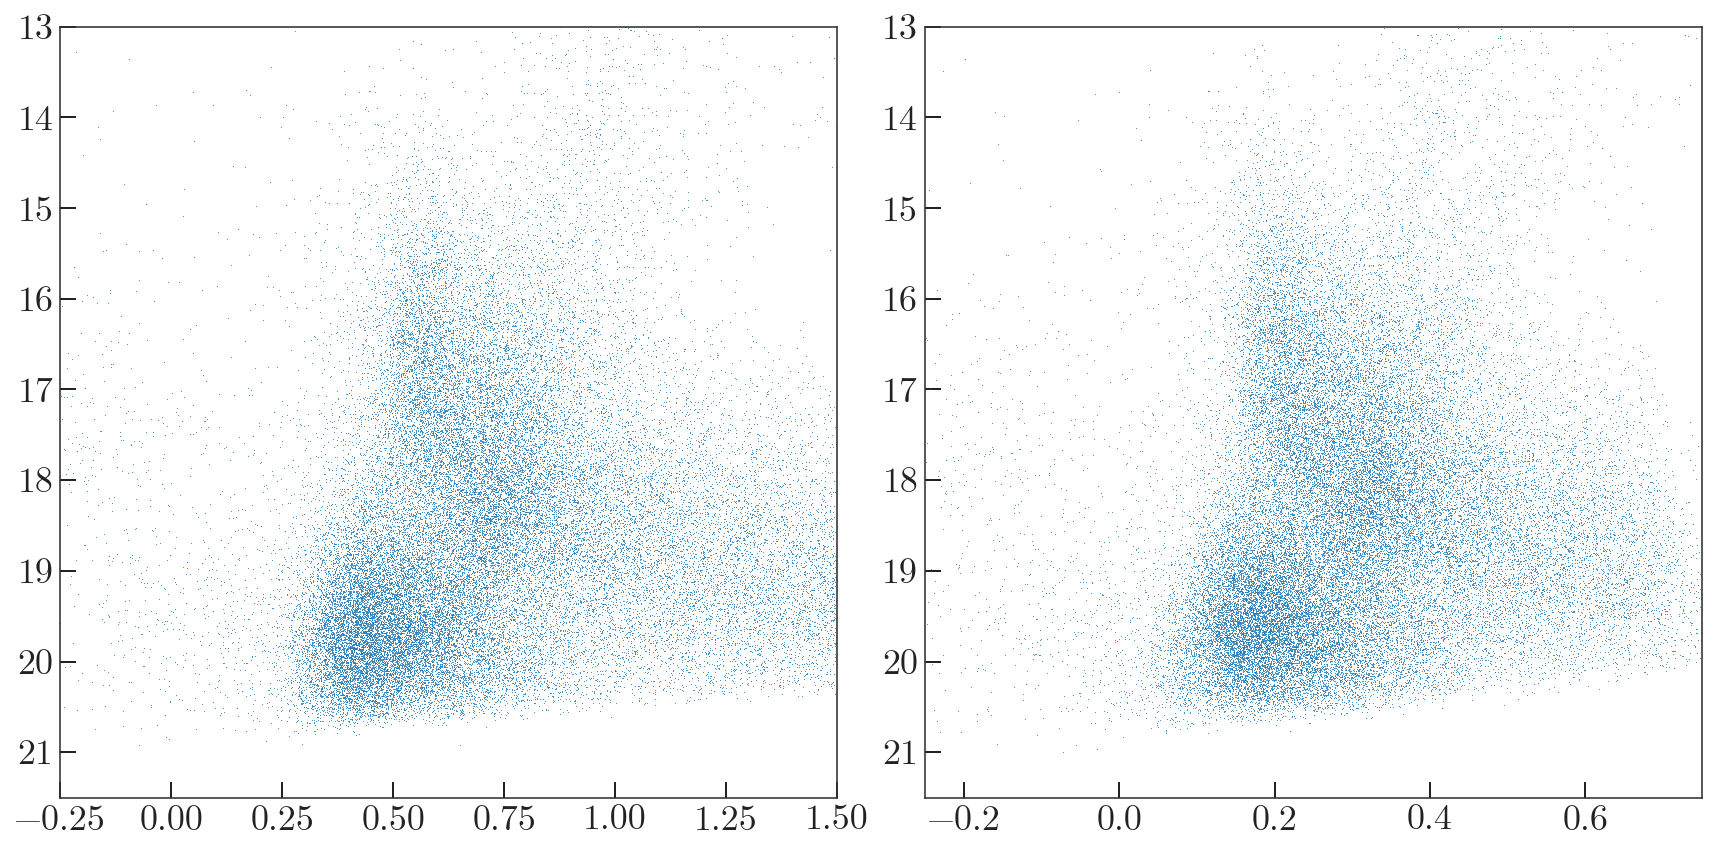

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

mask_ = pm_mask & m5_mask 

axes[0].plot((g.g_mean_psf_mag - g.i_mean_psf_mag)[mask_],
             g.i_mean_psf_mag[mask_], 
             marker=',', linestyle='none',
             alpha=0.8)

axes[0].set_xlim(-0.25, 1.5)
axes[0].set_ylim(21.5, 13.)

axes[1].plot((g.r_mean_psf_mag - g.z_mean_psf_mag)[mask_],
             g.z_mean_psf_mag[mask_], 
             marker=',', linestyle='none',
             alpha=0.8)

axes[1].set_xlim(-0.25, 0.75)
axes[1].set_ylim(21.5, 13.)
fig.tight_layout()